In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zero-width/attacked_text.csv
/kaggle/input/watermarked-and-unwatermarked-text-truncated/data_trunk.csv


In [2]:
!git clone https://github.com/jthickstun/watermark.git

Cloning into 'watermark'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 25), reused 67 (delta 14), pack-reused 0
Unpacking objects: 100% (80/80), 264.81 KiB | 5.52 MiB/s, done.


In [3]:
import os
os.chdir("/kaggle/working/watermark/demo")

In [4]:
import os, sys, argparse, time

import numpy as np
from transformers import AutoTokenizer
from mersenne import mersenne_rng

import pyximport
pyximport.install(reload_support=True, language_level=sys.version_info[0],
                  setup_args={'include_dirs':np.get_include()})
from levenshtein import levenshtein

def permutation_test(tokens,key,n,k,vocab_size,n_runs=100):
    rng = mersenne_rng(key)
    xi = np.array([rng.rand() for _ in range(n*vocab_size)], dtype=np.float32).reshape(n,vocab_size)
    test_result = detect(tokens,n,k,xi)

    p_val = 0
    for run in range(n_runs):
        xi_alternative = np.random.rand(n, vocab_size).astype(np.float32)
        null_result = detect(tokens,n,k,xi_alternative)

        # assuming lower test values indicate presence of watermark
        p_val += null_result <= test_result

    return (p_val+1.0)/(n_runs+1.0)


def detect(tokens,n,k,xi,gamma=0.0):
    m = len(tokens)
    n = len(xi)

    A = np.empty((m-(k-1),n))
    for i in range(m-(k-1)):
        for j in range(n):
            A[i][j] = levenshtein(tokens[i:i+k],xi[(j+np.arange(k))%n],gamma)

    return np.min(A)


In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-cpython-310/kaggle/working/watermark/demo/levenshtein.c:1205:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [5]:
from tqdm import tqdm
import pandas as pd

def main():
    # Read data from CSV using pandas
    data = pd.read_csv("/kaggle/input/zero-width/attacked_text.csv")
    # Combine filtered data
    split_point1 = int(len(data) / 3)
    split_point2 = split_point1 * 2
    split_point3 = 100
    part1 = data.iloc[:35] # First part
    part2 = data.iloc[35:69]  # Second part
    part3 = data.iloc[69:100]  # Third part (might be slightly bigger)
    # Load pre-trained tokenizer (replace with your desired tokenizer)
    tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

    # Progress bar with tqdm
    results = []
    for index, row in tqdm(part1.iterrows(), total=len(part1)):
        text = row["Attacked Text"]  # Assuming "Attacked Text" is the column containing text data
        actual_label = "watermarked" # Assuming "label" is the column containing actual label

        # Tokenize the text
        tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=2048).numpy()[0]

        t0 = time.time()
        pval = permutation_test(tokens, 42, 256, len(tokens), len(tokenizer))
        label = "watermarked" if pval <= 0.01 else "unwatermarked"
        results.append({"text": text, "p-value": pval, "label": label, "actual_label": actual_label})
        print(f"Row {index+1} - p-value: {pval:.4f}, label: {label} (elapsed time: {time.time()-t0:.2f}s)")

    # Create a pandas DataFrame from the results
    df_results = pd.DataFrame(results)
#     df_results.head(2)
    # Save the DataFrame (optional)
    df_results.to_csv("permutation_test_results_zerowidth.csv", index=False)
if __name__ == '__main__':
    main()

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

  3%|▎         | 1/35 [07:47<4:24:46, 467.26s/it]

Row 1 - p-value: 0.1881, label: unwatermarked (elapsed time: 467.23s)


  6%|▌         | 2/35 [17:52<5:01:43, 548.60s/it]

Row 2 - p-value: 0.5842, label: unwatermarked (elapsed time: 605.53s)


  9%|▊         | 3/35 [27:51<5:04:44, 571.39s/it]

Row 3 - p-value: 0.0990, label: unwatermarked (elapsed time: 598.52s)


 11%|█▏        | 4/35 [36:35<4:45:40, 552.91s/it]

Row 4 - p-value: 0.4851, label: unwatermarked (elapsed time: 524.58s)


 14%|█▍        | 5/35 [45:42<4:35:19, 550.66s/it]

Row 5 - p-value: 0.6931, label: unwatermarked (elapsed time: 546.67s)


 17%|█▋        | 6/35 [53:16<4:10:19, 517.90s/it]

Row 6 - p-value: 0.2574, label: unwatermarked (elapsed time: 454.30s)


 20%|██        | 7/35 [1:01:09<3:54:48, 503.14s/it]

Row 7 - p-value: 0.1782, label: unwatermarked (elapsed time: 472.76s)


 23%|██▎       | 8/35 [1:08:55<3:41:03, 491.25s/it]

Row 8 - p-value: 0.2475, label: unwatermarked (elapsed time: 465.77s)


 26%|██▌       | 9/35 [1:17:16<3:34:10, 494.25s/it]

Row 9 - p-value: 0.0099, label: watermarked (elapsed time: 500.84s)


 29%|██▊       | 10/35 [1:24:39<3:19:23, 478.55s/it]

Row 10 - p-value: 0.0099, label: watermarked (elapsed time: 443.38s)


 31%|███▏      | 11/35 [1:34:34<3:25:38, 514.11s/it]

Row 11 - p-value: 0.2574, label: unwatermarked (elapsed time: 594.76s)


 34%|███▍      | 12/35 [1:44:14<3:24:47, 534.24s/it]

Row 12 - p-value: 0.2871, label: unwatermarked (elapsed time: 580.28s)


 37%|███▋      | 13/35 [1:53:06<3:15:39, 533.61s/it]

Row 13 - p-value: 0.1287, label: unwatermarked (elapsed time: 532.15s)


 40%|████      | 14/35 [2:02:21<3:08:56, 539.83s/it]

Row 14 - p-value: 0.4158, label: unwatermarked (elapsed time: 554.19s)


 43%|████▎     | 15/35 [2:11:25<3:00:24, 541.24s/it]

Row 15 - p-value: 0.2574, label: unwatermarked (elapsed time: 544.49s)


 46%|████▌     | 16/35 [2:20:31<2:51:52, 542.74s/it]

Row 16 - p-value: 0.5347, label: unwatermarked (elapsed time: 546.24s)


 49%|████▊     | 17/35 [2:28:39<2:37:53, 526.33s/it]

Row 17 - p-value: 0.0198, label: unwatermarked (elapsed time: 488.14s)


 51%|█████▏    | 18/35 [2:36:41<2:25:20, 512.95s/it]

Row 18 - p-value: 0.0693, label: unwatermarked (elapsed time: 481.82s)


 54%|█████▍    | 19/35 [2:46:20<2:22:01, 532.61s/it]

Row 19 - p-value: 0.6139, label: unwatermarked (elapsed time: 578.40s)


 57%|█████▋    | 20/35 [2:56:24<2:18:33, 554.21s/it]

Row 20 - p-value: 0.1485, label: unwatermarked (elapsed time: 604.54s)


 60%|██████    | 21/35 [3:03:20<1:59:39, 512.81s/it]

Row 21 - p-value: 0.2376, label: unwatermarked (elapsed time: 416.28s)


 63%|██████▎   | 22/35 [3:11:14<1:48:32, 500.95s/it]

Row 22 - p-value: 0.1683, label: unwatermarked (elapsed time: 473.28s)


 66%|██████▌   | 23/35 [3:19:53<1:41:16, 506.37s/it]

Row 23 - p-value: 0.1089, label: unwatermarked (elapsed time: 519.01s)


 69%|██████▊   | 24/35 [3:28:55<1:34:47, 517.07s/it]

Row 24 - p-value: 0.5050, label: unwatermarked (elapsed time: 542.04s)


 71%|███████▏  | 25/35 [3:36:35<1:23:21, 500.12s/it]

Row 25 - p-value: 0.0099, label: watermarked (elapsed time: 460.56s)


 74%|███████▍  | 26/35 [3:45:21<1:16:09, 507.69s/it]

Row 26 - p-value: 0.1188, label: unwatermarked (elapsed time: 525.36s)


 77%|███████▋  | 27/35 [3:52:52<1:05:24, 490.61s/it]

Row 27 - p-value: 0.0495, label: unwatermarked (elapsed time: 450.74s)


 80%|████████  | 28/35 [4:01:08<57:25, 492.27s/it]  

Row 28 - p-value: 0.3960, label: unwatermarked (elapsed time: 496.13s)


 83%|████████▎ | 29/35 [4:09:11<48:56, 489.47s/it]

Row 29 - p-value: 0.3960, label: unwatermarked (elapsed time: 482.95s)


 86%|████████▌ | 30/35 [4:17:05<40:24, 484.95s/it]

Row 30 - p-value: 0.2673, label: unwatermarked (elapsed time: 474.39s)


 89%|████████▊ | 31/35 [4:27:09<34:42, 520.60s/it]

Row 31 - p-value: 0.3762, label: unwatermarked (elapsed time: 603.79s)


 91%|█████████▏| 32/35 [4:34:14<24:36, 492.11s/it]

Row 32 - p-value: 0.0099, label: watermarked (elapsed time: 425.64s)


 94%|█████████▍| 33/35 [4:42:04<16:10, 485.41s/it]

Row 33 - p-value: 0.3861, label: unwatermarked (elapsed time: 469.76s)


 97%|█████████▋| 34/35 [4:49:52<08:00, 480.06s/it]

Row 34 - p-value: 0.1287, label: unwatermarked (elapsed time: 467.59s)


100%|██████████| 35/35 [4:59:08<00:00, 512.81s/it]

Row 35 - p-value: 0.4554, label: unwatermarked (elapsed time: 556.06s)


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


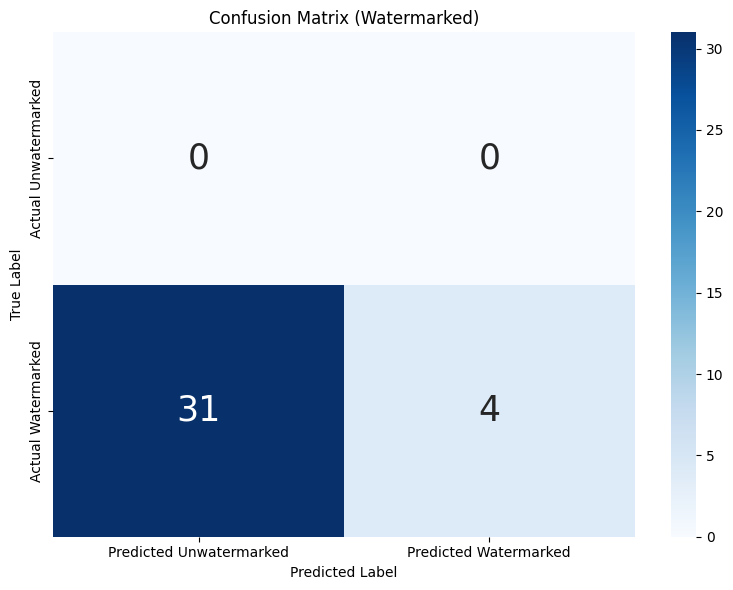


Classification Metrics:
Accuracy: 11.4286
F1-score: 20.5128
Precision: 100.0000
Recall: 11.4286


In [7]:
def evaluate_classification(file_path):

    # Evaluates a classification model using various metrics, reading data from a CSV file and creates a confusion matrix heatmap using seaborn.

    # Read the CSV file assuming 'label' and 'actual_label' columns are present
    df = pd.read_csv(file_path)

    # Extract true labels (assuming 'actual_label' column)
    y_true = df['actual_label'].tolist()

    # Extract predicted labels (assuming 'label' column)
    y_pred = df['label'].tolist()

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
      # Define custom labels for the confusion matrix

    # Create a confusion matrix heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',annot_kws={'fontsize': 25})
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (Watermarked)')
    plt.xticks([0.5, 1.5], ['Predicted Unwatermarked', 'Predicted Watermarked'])
    plt.yticks([0.5, 1.5], ['Actual Unwatermarked', 'Actual Watermarked'])    
    plt.tight_layout()
    plt.show()
    return cm, accuracy, f1, precision, recall

# Specify the file path (assuming you're using Kaggle)
file_path = "/kaggle/working/watermark/demo/permutation_test_results_zerowidth.csv"

# Evaluate the classification
cm, accuracy, f1, precision, recall = evaluate_classification(file_path)

# Print classification metrics (same as before)
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"F1-score: {f1 * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")


In [8]:
def evaluate_misclassifications(file_path):
    # Evaluates the average absolute difference between misclassified p-values and the threshold (0.1) for watermarked images.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for misclassified watermarked images
    misclassified_watermarked = df[(df['label'] != df['actual_label']) & (df['actual_label'] == 'watermarked')]

    # Check if there are any misclassified watermarked images
    if len(misclassified_watermarked) == 0:
        print("No misclassified watermarked images found.")
        return None

    # Calculate absolute difference between misclassified p-values and the threshold (0.1)
    abs_diff = np.abs(misclassified_watermarked['p-value'] - 0.1)

    # Calculate average absolute difference
    average_diff = np.mean(abs_diff)

    return average_diff

# Specify the file path
file_path = "/kaggle/working/watermark/demo/permutation_test_results_zerowidth.csv"

# Evaluate misclassifications
average_diff = evaluate_misclassifications(file_path)

if average_diff is not None:
    print(f"Average absolute difference for misclassified watermarked images: {average_diff:.4f}")


Average absolute difference for misclassified watermarked images: 0.2027


In [9]:
def get_incorrect_samples(file_path):
   
    # Extracts all samples from a CSV file where 'label' and 'actual_label' differ.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for rows where label doesn't equal actual_label
    incorrect_samples = df[df['label'] != df['actual_label']]
    incorrect_samples = incorrect_samples.sort_values(by='actual_label')

    return incorrect_samples

file_path = "/kaggle/working/watermark/demo/permutation_test_results_zerowidth.csv"
incorrect_df = get_incorrect_samples(file_path)


incorrect_df.head(len(incorrect_df))

,text,p-value,label,actual_label
0,Some c‌omp‌an​ies ‌f‌ai‌led to pay t​heir work...,0.188119,unwatermarked,watermarked
32,‍Elect​‌ions are do‍ne‍ on spec​‍i​‍fic da‌te​...,0.386139,unwatermarked,watermarked
30,Te‌‌acher ac​commodation f‍‌acilitat​ion ​e​ns...,0.376238,unwatermarked,watermarked
29,There should be ju​st‌ifiable‍ re‍asons for em...,0.267327,unwatermarked,watermarked
28,Aim to l‍ive pea​‍ceful‍ly with every‍one ‍in​...,0.396040,unwatermarked,watermarked
27,Th​i‍s‌ e​lection is goi‍ng to be very inter‌e...,0.396040,unwatermarked,watermarked
26,‍Ther​e ar‌e a lo‍t ‌of c‍ars com‍ing inside t...,0.049505,unwatermarked,watermarked
25,O​ur m‍a‌th​ema​tics teacher​ ​inspired ​us to...,0.118812,unwatermarked,watermarked
23,Ch​urch ‌leaders ​‍have ​met‍ th​e m‌iniste‌r ...,0.504950,unwatermarked,watermarked
22,Mothers are ‍gr​ateful for the ‌re​nov‌at​‌​io...,0.108911,unwatermarked,watermarked
